In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.10 torchvision -f https://download.pytorch.org/whl/cu113/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# opencv is pre-installed on colab
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
!python -m pip install detectron2==0.6 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Using cached torchvision-0.14.1-cp38-cp38-manylinux1_x86_64.whl (24.2 MB)
  Using cached torchvision-0.14.0-cp38-cp38-manylinux1_x86_64.whl (24.3 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.13.1%2Bcu113-cp38-cp38-linux_x86_64.whl (23.4 MB)
  Using cached torchvision-0.13.1-cp38-cp38-manylinux1_x86_64.whl (19.1 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.13.0%2Bcu113-cp38-cp38-linux_x86_64.whl (23.4 MB)
  Using cached torchvision-0.13.0-cp38-cp38-manylinux1_x86_64.whl (19.1 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.12.0%2Bcu113-cp38-cp38-linux_x86_64.whl (22.3 MB)
  Using cached torchvision-0.12.0-cp38-cp38-manylinux1_x86_64.whl (21.0 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.11.3%2Bcu113-cp38-cp38-l

In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from cv2 import imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [34]:
! pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="4U1veSGmQ7OeQ9V8rnHD")
project = rf.workspace("neuralnetworkproject-jx4is").project("nn-vwkfp")
dataset = project.version(14).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to NN-14 in coco:: 100%|██████████| 44/44 [00:00<00:00, 1089.14it/s]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp /content/drive/MyDrive/models/best/model_final.pth /content/output

In [35]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train2", {}, "./NN-14/train/_annotations.coco.json", "./NN-14/train")
register_coco_instances("my_dataset_val2", {}, "./NN-14/valid/_annotations.coco.json", "./NN-14/valid")
register_coco_instances("my_dataset_test2", {}, "./NN-14/test/_annotations.coco.json", "./NN-14/test")

WARNING [02/04 19:04:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 19:04:10 d2.data.datasets.coco]: Loaded 33 images in COCO format from ./NN-14/train/_annotations.coco.json


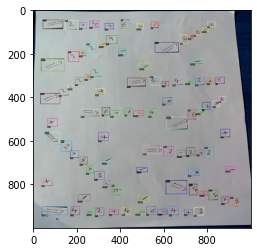

In [36]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train2")
dataset_dicts = DatasetCatalog.get("my_dataset_train2")
from matplotlib import pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
window_name = 'image'
for d in dataset_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [28]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Train Model

In [ ]:
# from detectron2.config import get_cfg
# #from detectron2.evaluation.coco_evaluation import COCOEvaluator
# import os

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# # cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ("my_dataset_val",)

# cfg.DATALOADER.NUM_WORKERS = 4
# # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# # cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
# cfg.MODEL.WEIGHTS = "output/model_final.pth"
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.007


# cfg.SOLVER.WARMUP_ITERS = 500
# cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (300, 600)
# cfg.SOLVER.GAMMA = 0.005




# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1

# cfg.TEST.EVAL_PERIOD = 500


# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

[01/30 03:12:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)


[01/30 03:12:57 d2.utils.events]:  eta: 0:09:33  iter: 19  total_loss: 0.4124  loss_cls: 0.09033  loss_box_reg: 0.2202  loss_rpn_cls: 0.01044  loss_rpn_loc: 0.08814  time: 0.5692  data_time: 0.1042  lr: 8.064e-06  max_mem: 4393M
[01/30 03:13:08 d2.utils.events]:  eta: 0:09:22  iter: 39  total_loss: 0.4024  loss_cls: 0.07822  loss_box_reg: 0.2162  loss_rpn_cls: 0.008718  loss_rpn_loc: 0.09193  time: 0.5721  data_time: 0.0015  lr: 9.184e-06  max_mem: 4393M
[01/30 03:13:20 d2.utils.events]:  eta: 0:09:05  iter: 59  total_loss: 0.3962  loss_cls: 0.08079  loss_box_reg: 0.2231  loss_rpn_cls: 0.009824  loss_rpn_loc: 0.09013  time: 0.5718  data_time: 0.0017  lr: 1.0304e-05  max_mem: 4393M
[01/30 03:13:31 d2.utils.events]:  eta: 0:08:53  iter: 79  total_loss: 0.3873  loss_cls: 0.07631  loss_box_reg: 0.1991  loss_rpn_cls: 0.00911  loss_rpn_loc: 0.08789  time: 0.5725  data_time: 0.0015  lr: 1.1424e-05  max_mem: 4393M
[01/30 03:13:43 d2.utils.events]:  eta: 0:08:44  iter: 99  total_loss: 0.3751  l

# Loading Model

In [40]:
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train2",)
cfg.DATASETS.TEST = ("my_dataset_val2",)

cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.007


cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (300, 600)
cfg.SOLVER.GAMMA = 0.005




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [41]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)
# evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "my_dataset_test")
# inference_on_dataset(trainer.model, val_loader, evaluator)

In [39]:
cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.DATASETS.TEST = ("my_dataset_test2", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test2")

In [46]:
from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/Number_finder-5/train/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [52]:
im = cv2.imread("./test6.jpg")
im = cv2.resize(im, (1000,1000))
outputs = predictor(im)

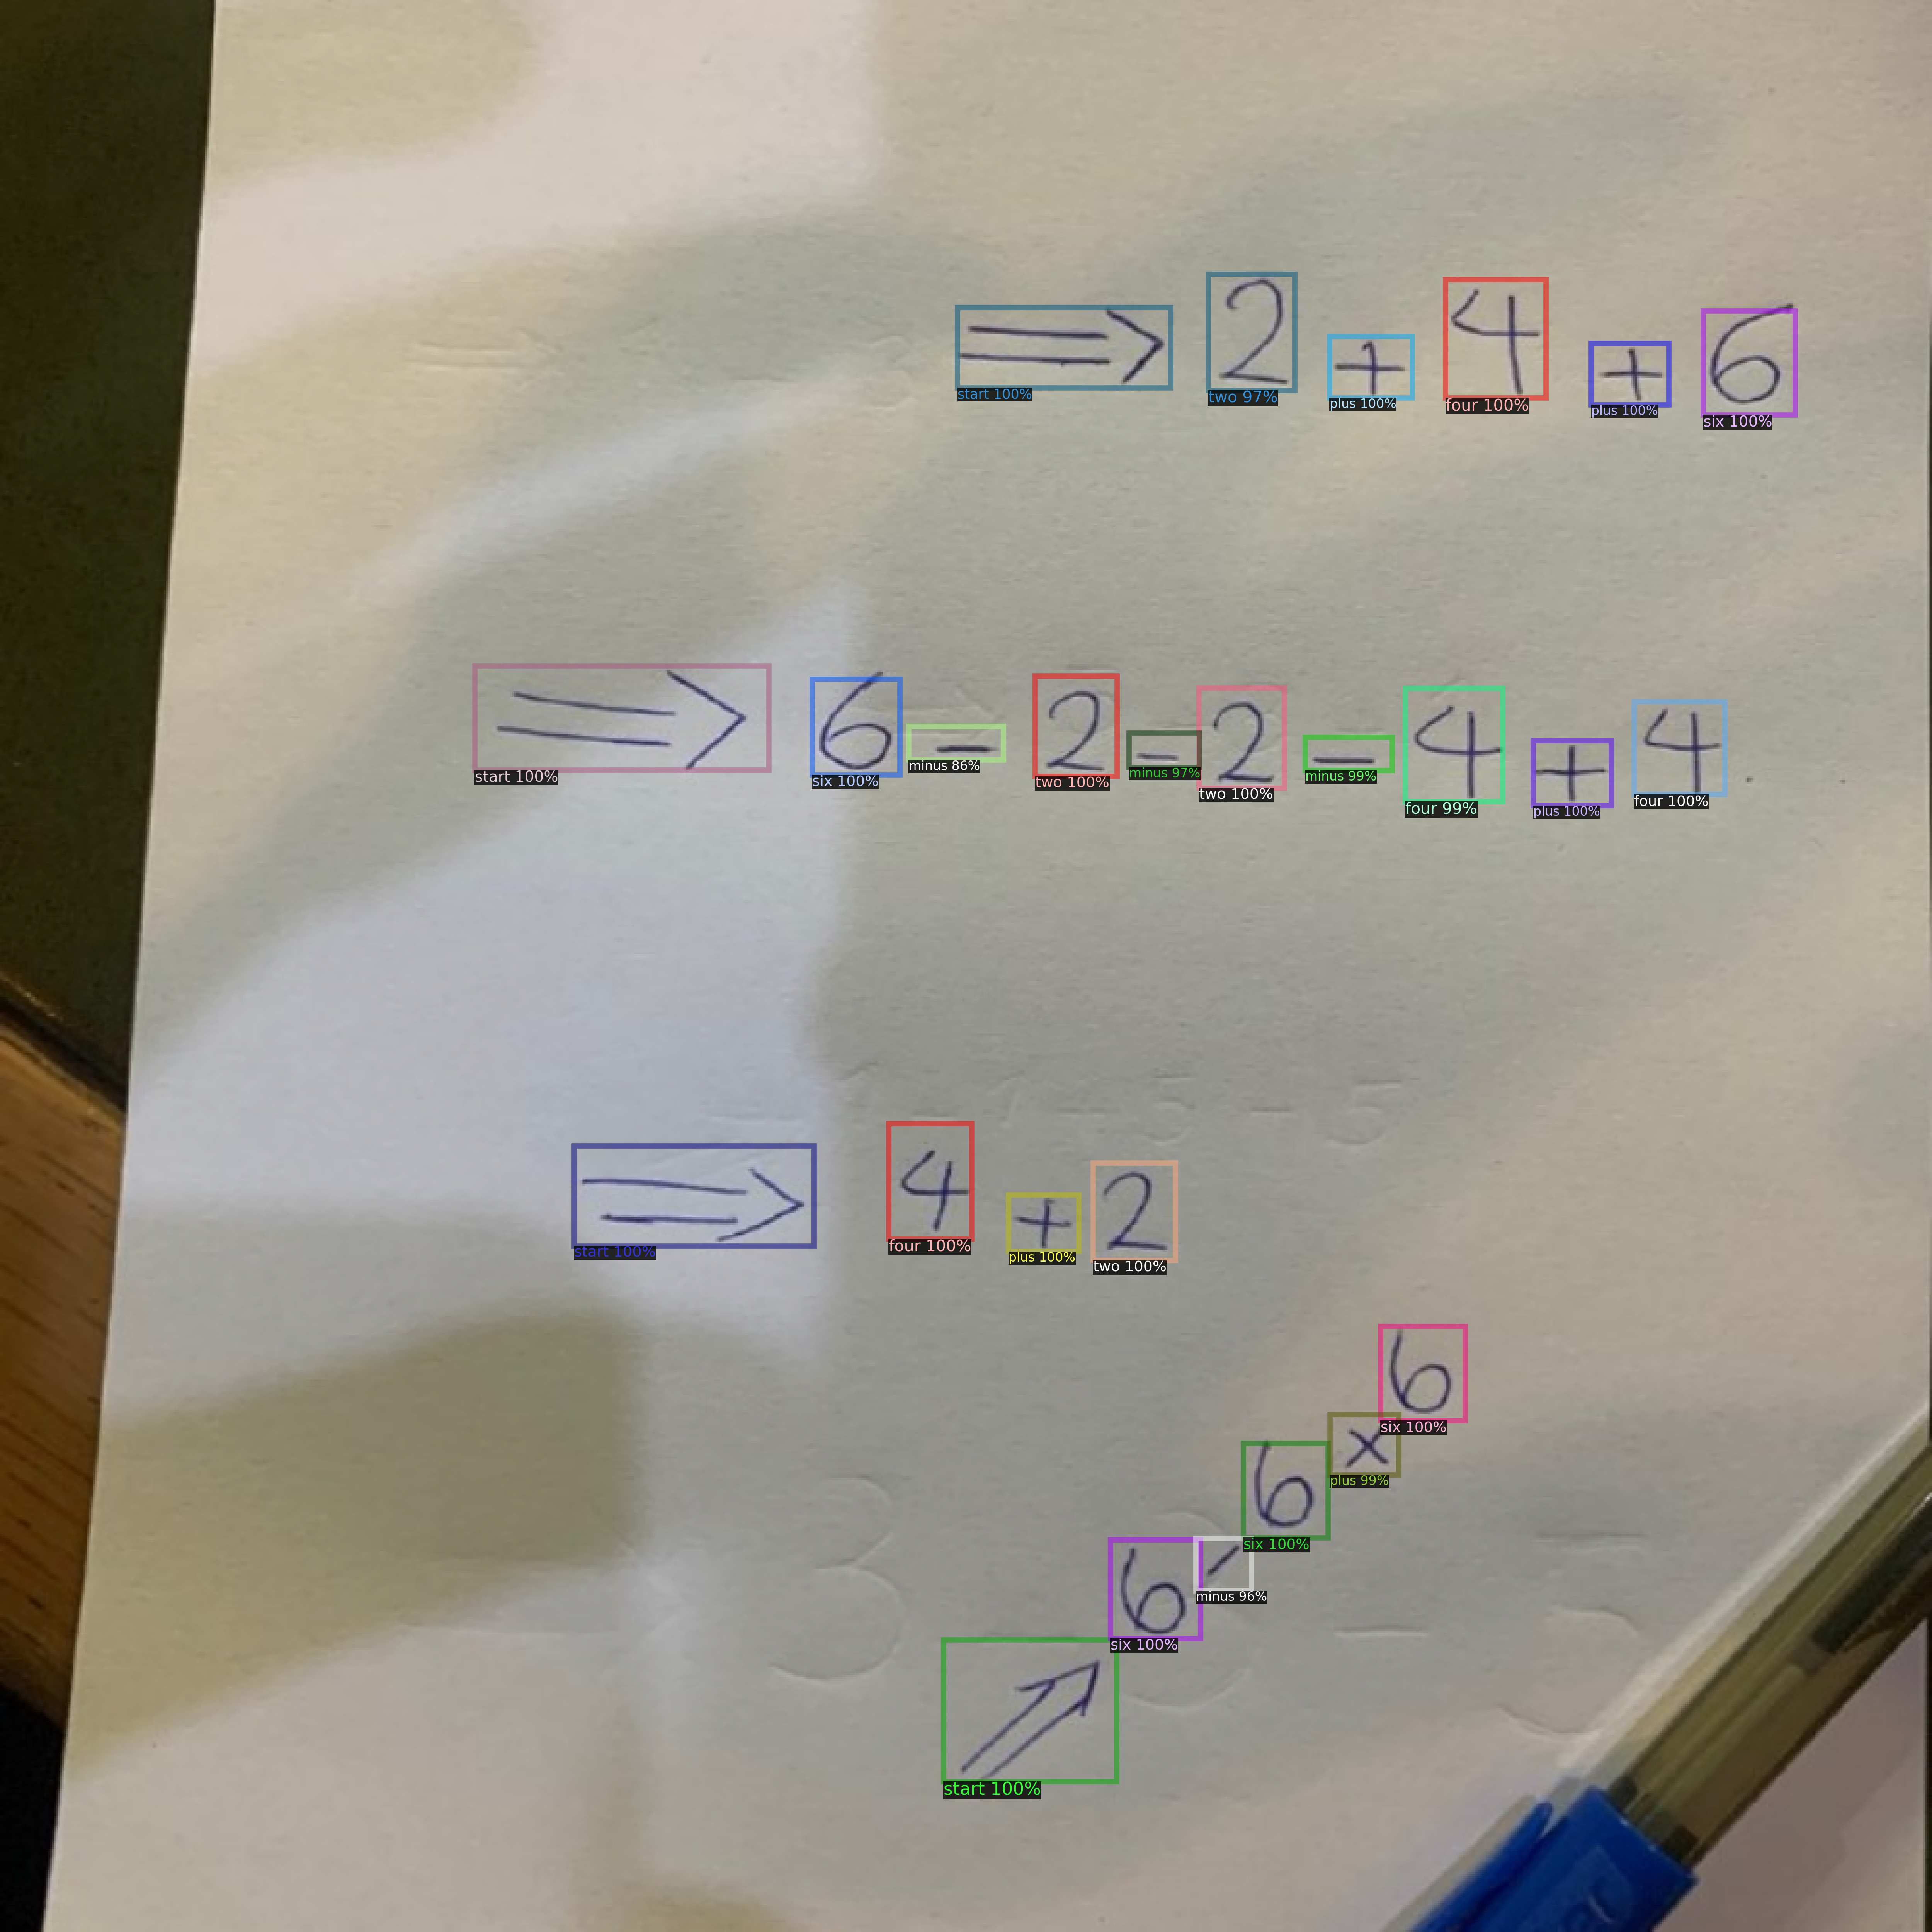

True

In [53]:
from matplotlib import pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
cv2.imwrite("final.jpg", out.get_image()[:, :, ::-1])

In [63]:
classes=np.array(outputs["instances"].pred_classes.to("cpu"))
boxes = outputs["instances"].get_fields().get("pred_boxes").to("cpu")

In [64]:
boxes_temp=boxes.tensor.numpy()
box=[]
for i in range(len(boxes)):
  box.append(np.append(boxes_temp[i],boxes[i].get_centers().numpy()))
boxes = np.array(box)
sorted_box = boxes[boxes[:,4].argsort()] 

In [65]:
box=[]
for i in range(len(sorted_box)):
    indices = np.where(boxes == sorted_box[i])[0][0]
    box.append((sorted_box[i],classes[indices]))
box=np.array(box)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [67]:
classes = np.where(box[:,1] == 5)
classes=np.reshape(classes,(4))

In [68]:
equations=[]
for i in range(len(classes)):
  equations.append([])

In [71]:
equation_num=0
equations=[]
for i in range(len(classes)):
  equations.append([])
for i in classes:
    y_min=5000
    y_max=0
    choosen_box = box[i]
    indice_k = i
    while True:
        found= False
        y_min = min(choosen_box[0][1]-40,y_min)
        y_max = max(choosen_box[0][3]+40,y_max)
        possible = box[indice_k+1:]
        for j in range(len(possible)):
            y=(possible[j][0][5])
            if y_min <= y <= y_max:
                if possible[j][1] == 5:
                    continue
                if choosen_box[1] != 5:
                    equations[equation_num].append(choosen_box)
                indice_k = indice_k+j+1
                choosen_box = box[indice_k]
                found =True
                break
        if not found:
            if choosen_box[1] != 5:
                equations[equation_num].append(choosen_box)
            equation_num+=1
            break

In [72]:
answers=[]
for i in equations:
    temp = np.array(i)
    string=""
    min_y= float("inf")
    max_y=float("-inf")
    min_x= float("inf")
    max_x=float("-inf")
    for j in temp:
        if j[0][3]>max_y:
            max_y=j[0][3]
        if j[0][1]<min_y:
            min_y=j[0][1]
        if j[0][2]>max_x:
            max_x=j[0][2]
        if j[0][0]<min_x:
            min_x=j[0][0]
        if j[1]==1:
            string+="4"
        if j[1]==2:
            string+="-"
        if j[1]==3:
            string+="+"
        if j[1]==4:
            string+="6"
        if j[1]==5:
            continue
        if j[1]==6:
            string+="2"
    try:
        answers.append(np.array([eval(string),(min_x,min_y,max_x,max_y)]))
    except:
        continue

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


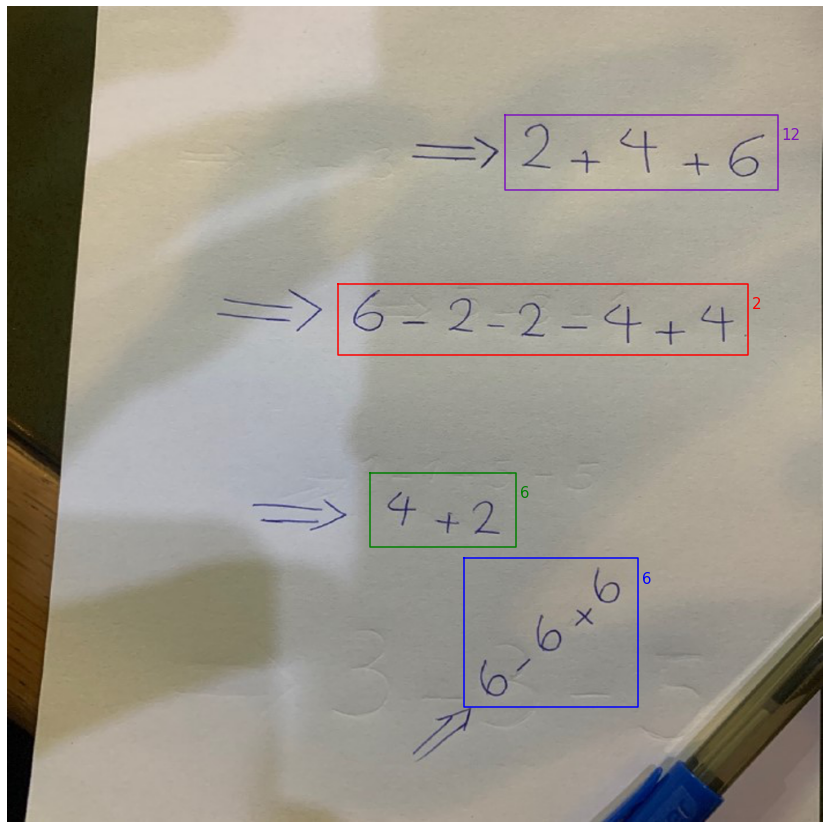

In [88]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('./test6.jpg')
im=im.resize((1000,1000))

# Create figure and axes
fig, ax = plt.subplots(figsize=(15, 15))
# Display the image
ax.imshow(im)
ax.axis('off')
# Coordinates of rectangle vertices
# in clockwise order
colors=["r","g","b","#7E14BE"]
for i in range(len(answers)):
    temp1=answers[i][1]
    xs = [temp1[0]-15,temp1[0]-15,temp1[2]+15,temp1[2]+15,temp1[0]-15]
    ys = [temp1[1]-10,temp1[3]+10,temp1[3]+10,temp1[1]-10,temp1[1]-10]
    ax.plot(xs, ys,colors[i])
    ax.text(temp1[2]+20,temp1[1]+20,str(answers[i][0]),color=colors[i],fontsize=15)
fig.show()
fig.savefig("result.jpg")